In [2]:
import os 

import fiona #must be import before geopandas
import geopandas as gpd
import rasterio
import xarray as xr
import re
import rtree
import shapely
import pickle

#from cartopy import crs
import collections
import cv2
import math
from glob import glob
from tqdm.notebook import tqdm_notebook

# Standard packages
import tempfile
import warnings
import urllib
import shutil

# Less standard, but still pip- or conda-installable
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import data_eng.az_proc as ap
import data_eng.form_calcs as fc

from lxml.etree import Element,SubElement,tostring
import xml.dom.minidom
from xml.dom.minidom import parseString
import xml.etree.ElementTree as et
from xml.dom import minidom

#import requests
from PIL import Image
from io import BytesIO
import tqdm

In [3]:
parent_directory = "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//"

tile_names_tile_urls_complete_array = np.load("image_download_azure/tile_name_tile_url_complete_array.npy")

tiles_labeled = "tile_name_tile_url_labeled.npy"
tiles_labeled_from_complete_set = np.load(tiles_labeled)

tracker_file_path = 'outputs/tile_img_annotation_annotator.npy'
tile_img_annotation = np.load(tracker_file_path)
tile_img_annotation_annotator = np.load("outputs/tile_img_annotation_annotator.npy")

tiles_errors = 'tile_name_tile_url_error_downloading.npy'
tiles_errors = np.load(tiles_errors)

#create folder to hold tiles in completed dataset
complete_dataset_path = "verified/complete_dataset"
complete_dataset_path = os.path.join(parent_directory, complete_dataset_path)
tiles_complete_dataset_path = os.path.join(complete_dataset_path,"tiles")
tiles_xml_complete_dataset_path = os.path.join(complete_dataset_path,"tiles_xml")
positive_images_complete_dataset_path = os.path.join(complete_dataset_path,"chips_positive")
#verified_sets_path = os.path.join(complete_dataset_path,"verified//verified_sets")

os.makedirs(tiles_complete_dataset_path, exist_ok=True)

tile_names_tile_urls_complete_array_unique_standard_tile_names = np.load("tile_names_tile_urls_complete_array_unique_standard_tile_names.npy")
image_characteristics = pd.read_csv("image_characteristics.csv")
tile_names_tile_urls_complete_array_unique_standard_tile_names = np.load("tile_names_tile_urls_complete_array_unique_standard_tile_names.npy")

#NAIP quad map
quad_indicies_path = "C:/Users/rapiduser/Box/EPA STAR 2019 (Community Resistance to Environmental Disasters)/Data/AST Datasets/MapIndices_National_GDB/MapIndices_National_GDB.gdb"
#fiona.listlayers(quad_indicies_path)

In [4]:
def get_tile_names_from_chip_names(directory):
    tile_names = []
    for chip_name in os.listdir(directory):
        chip_name = os.path.splitext(chip_name)[0]#remove ext
        chip_name, _ = chip_name.rsplit("_",1)
        tile_names.append(chip_name.split("_",4)[4] + ".tif")
    return(np.unique(tile_names))

def positive_images_to_array(images_dir_path):
    images = np.array(os.listdir(os.path.join(images_dir_path)))
    imgsr = np.zeros((len(images),512,512), dtype='uint8')
    imgsg = np.zeros((len(images),512,512), dtype='uint8')
    imgsb = np.zeros((len(images),512,512), dtype='uint8')
    
    for num in tqdm.tqdm(range(len(images))):    
        image = cv2.imread(os.path.join(images_dir_path, images[num])) #open image
        imgsr[num,:,:] = image[:,:,0]
        imgsg[num,:,:] = image[:,:,1]
        imgsb[num,:,:] = image[:,:2]
    return(images, imgsr, imgsg, imgsb)

def positive_images_to_array_v2(images_dir_path):
    images = np.array(os.listdir(os.path.join(images_dir_path)))
    image_array = np.zeros((len(images),512,512, 3), dtype='uint8')

    for num in tqdm.tqdm(range(len(images))):    
        image = cv2.imread(os.path.join(images_dir_path, images[num])) #open image
        image_array[num,:,:,:] = image
        
    return(images, image_array)

def tile_to_chip_array(tile,x, y, item_dim):
    """
    x: row index
    y: col index
    """
    chip_img = tile[y*item_dim:y*item_dim+item_dim, x*(item_dim):x*(item_dim)+item_dim]
    
    #add in back space if it is the edge of an image
    if chip_img.shape[0] != 512:  #Height
        black_height = 512  - chip_img.shape[0] #Height
        black_width = 512 #- chip_img.shape[1] #width
        black_img = np.zeros((black_height,black_width,3), np.uint8)
        chip_img = np.concatenate([chip_img, black_img])

    if chip_img.shape[1] != 512: #width
        black_height = 512 #- chip_img.shape[0] #Height
        black_width = 512 - chip_img.shape[1] #width
        black_img = np.zeros((black_height,black_width,3), np.uint8)
        chip_img = np.concatenate([chip_img, black_img],1)
    
    return(chip_img)


def confirm_correct_image(tiles_dir, tiles_in_directory, images_in_directory, images_in_directory_array):
    #index over the tiles with corresponding images in the given directory
    for tile_name in tqdm.tqdm(tiles_in_directory): 
        print(tile_name)
        file_name, ext = os.path.splitext(tile_name) # File name
        
        #get tile shape
        item_dim = int(512)          
        tile = cv2.imread(os.path.join(tiles_dir, tile_name)) 
        tile_height,  tile_width,  tile_channels = tile.shape #the size of the tile 

        #determine tile dimensions
        #divide the tile into 512 by 512 chips (rounding up)
        row_index = math.ceil(tile_height/512) 
        col_index = math.ceil(tile_width/512)

        
        print(tile_height,tile_width)
        print(row_index*512, col_index*512)

        count = 1  
        for y in range(0, col_index):
            for x in range(0, row_index):
                chip_name_temp = file_name+ '_' + str(count).zfill(6) + '.jpg'
                #create a numpy array of each correctly chipped images 
                correct_image = tile_to_chip_array(tile, x, y, item_dim)
                count += 1  

                #Identify if images that are contained in the directory of interest
                confirmed_chip = [string for string in images_in_directory if chip_name_temp in string]
                if len(confirmed_chip) > 0:
                    print(confirmed_chip)
                    index, = np.where(images_in_directory == confirmed_chip)
                    #obtain a numpy array of the image in the directory of interest
                    image_in_directory_array = images_in_directory_array[index[0]] #use the actual value of index (saved as an array)
                    print(image_in_directory_array.shape)
                    print(correct_image.shape)
                    if not np.array_equal(image_in_directory_array,correct_image):
                        print("Error :(")
                        plt.figure()
                        plt.imshow(correct_image)
                        plt.imshow(image_in_directory_array)
                        plt.show()                        


                        #cv2.destroyAllWindows()

In [ ]:
plt.figure()
plt.imshow(correct_image)
plt.imshow(image_in_directory_array)
plt.show()  

In [6]:
#first folder in unverified

#get directories that need to be chec
student_reviewed_unverified_images_set1 = ap.img_path_anno_path(ap.list_of_sub_directories(os.path.join(parent_directory,"unverified_images\student_reviewed_unverified_images_set1")))

#identify tiles that have corresponding images in directory
tiles_in_directory = get_tile_names_from_chip_names(student_reviewed_unverified_images_set1[1][0])
    
#check data that needs to be checked
images_in_directory, images_in_directory_array = positive_images_to_array_v2(student_reviewed_unverified_images_set1[1][0])


100%|██████████| 331/331 [00:07<00:00, 44.19it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

m_2909006_sw_15_060_20190707.tif
12876 11411
13312 11776
False
m_2909006_sw_15_060_20190707_000109.jpg ['la_60cm_2019_29090_m_2909006_sw_15_060_20190707_000109.jpg']
4 4
108886269 108892694
Error :(


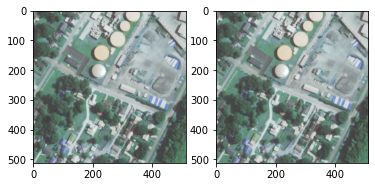

False
m_2909006_sw_15_060_20190707_000139.jpg ['la_60cm_2019_29090_m_2909006_sw_15_060_20190707_000139.jpg']
8 5
148612061 148635432
Error :(


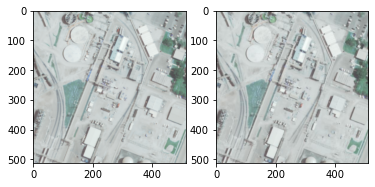

False
m_2909006_sw_15_060_20190707_000163.jpg ['la_60cm_2019_29090_m_2909006_sw_15_060_20190707_000163.jpg']
6 6
142045630 142056098
Error :(


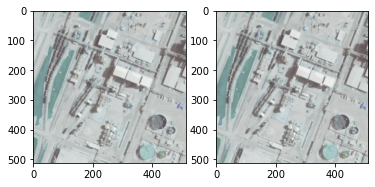

False
m_2909006_sw_15_060_20190707_000164.jpg ['la_60cm_2019_29090_m_2909006_sw_15_060_20190707_000164.jpg']
7 6
132853296 132868893
Error :(


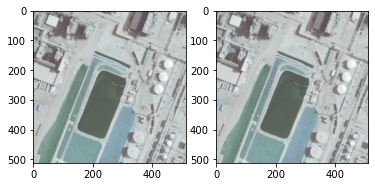

False
m_2909006_sw_15_060_20190707_000165.jpg ['la_60cm_2019_29090_m_2909006_sw_15_060_20190707_000165.jpg']
8 6
147910273 147907003
Error :(


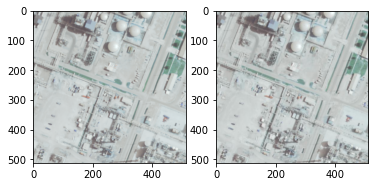

False
m_2909006_sw_15_060_20190707_000166.jpg ['la_60cm_2019_29090_m_2909006_sw_15_060_20190707_000166.jpg']
9 6
133032486 133025931
Error :(


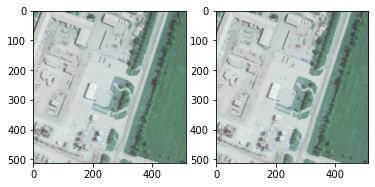

False
m_2909006_sw_15_060_20190707_000189.jpg ['la_60cm_2019_29090_m_2909006_sw_15_060_20190707_000189.jpg']
6 7
148729375 148727201
Error :(


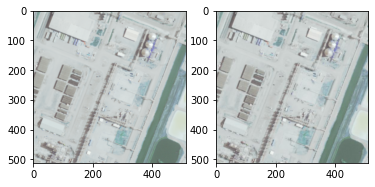

False
m_2909006_sw_15_060_20190707_000190.jpg ['la_60cm_2019_29090_m_2909006_sw_15_060_20190707_000190.jpg']
7 7
148866828 148854757
Error :(


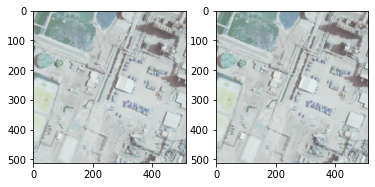

False
m_2909006_sw_15_060_20190707_000287.jpg ['la_60cm_2019_29090_m_2909006_sw_15_060_20190707_000287.jpg']
0 11
131848841 131850267
Error :(


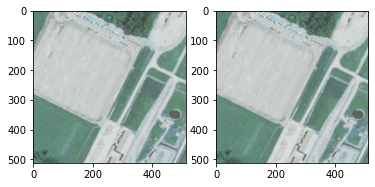

  2%|▎         | 1/40 [00:09<06:06,  9.41s/it]

m_2909007_nw_15_060_20190707.tif
12703 11414
12800 11776
False
m_2909007_nw_15_060_20190707_000296.jpg ['la_60cm_2019_29090_m_2909007_nw_15_060_20190707_000296.jpg']
20 11
108182105 108176652
Error :(


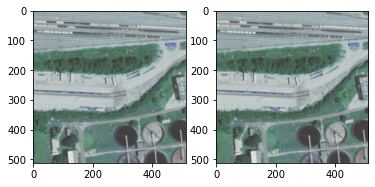

False
m_2909007_nw_15_060_20190707_000297.jpg ['la_60cm_2019_29090_m_2909007_nw_15_060_20190707_000297.jpg']
21 11
102221354 102213526
Error :(


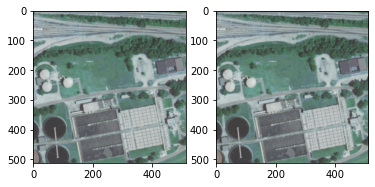

False
m_2909007_nw_15_060_20190707_000321.jpg ['la_60cm_2019_29090_m_2909007_nw_15_060_20190707_000321.jpg']
20 12
107687527 107670190
Error :(


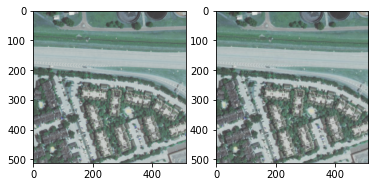

False
m_2909007_nw_15_060_20190707_000322.jpg ['la_60cm_2019_29090_m_2909007_nw_15_060_20190707_000322.jpg']
21 12
115331615 115315595
Error :(


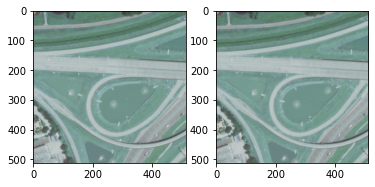

  5%|▌         | 2/40 [00:16<05:13,  8.26s/it]

m_2909007_se_15_060_20190707.tif


  5%|▌         | 2/40 [00:23<07:25, 11.73s/it]


KeyboardInterrupt: 

In [38]:
#ensure chips correspond to the standard tile name included in their name
#does not address the chips with the same standard tile names
for tile_name in tqdm.tqdm(tiles_in_directory): 
    print(tile_name)
    file_name, ext = os.path.splitext(tile_name) # File name

    #get tile shape
    item_dim = int(512)          
    tile = cv2.imread(os.path.join(tiles_complete_dataset_path, tile_name)) 
    tile_height,  tile_width,  tile_channels = tile.shape #the size of the tile 

    #determine tile dimensions
    #divide the tile into 512 by 512 chips (rounding up)
    row_index = math.ceil(tile_height/512) 
    col_index = math.ceil(tile_width/512)


    print(tile_height,tile_width)
    print(row_index*512, col_index*512)

    count = 1  
    for y in range(0, col_index):
        for x in range(0, row_index):
            chip_name_temp = file_name+ '_' + str(count).zfill(6) + '.jpg'
            #create a numpy array of each correctly chipped images 
            correct_image = tile_to_chip_array(tile, x, y, item_dim)
            count += 1  

            #Identify if images that are contained in the directory of interest
            confirmed_chip = [string for string in images_in_directory if chip_name_temp in string]
            if len(confirmed_chip) > 0:
                index, = np.where(images_in_directory == confirmed_chip)
                #obtain a numpy array of the image in the directory of interest
                image_in_directory_array = images_in_directory_array[index[0]] #use the actual value of index (saved as an array)
                print(np.array_equal(image_in_directory_array,correct_image))
                if not np.array_equal(image_in_directory_array,correct_image, equal_nan=True):
                    print(chip_name_temp, confirmed_chip)
                    print(x,y)
                    print(np.sum(correct_image), np.sum(image_in_directory_array))

                    print("Error :(")
                    
                    fig, (ax1, ax2) = plt.subplots(1, 2)
                    ax1.imshow(correct_image)
                    ax2.imshow(image_in_directory_array)
                    plt.show()                        


In [7]:
index, = np.where(images_in_directory == "la_60cm_2019_29090_m_2909006_sw_15_060_20190707_000109.jpg")
#obtain a numpy array of the image in the directory of interest
image_in_directory_array = images_in_directory_array[index[0]]

In [8]:
tile = cv2.imread(os.path.join(tiles_complete_dataset_path, "m_2909006_sw_15_060_20190707.tif")) 
correct_image = tile_to_chip_array(tile, 4, 4, 512)

In [9]:
#https://pyimagesearch.com/2017/06/19/image-difference-with-opencv-and-python/
gray_image_in_directory_array = cv2.cvtColor(image_in_directory_array, cv2.COLOR_BGR2GRAY)
gray_correct_image = cv2.cvtColor(correct_image, cv2.COLOR_BGR2GRAY)

In [18]:
from skimage.metrics import structural_similarity as compare_ssim
import imutils


In [13]:
(score, diff) = compare_ssim(gray_image_in_directory_array, gray_correct_image, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

SSIM: 0.9806602615788806


In [19]:
# threshold the difference image, followed by finding contours to
# obtain the regions of the two input images that differ
thresh = cv2.threshold(diff, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [ ]:
#Image Difference with OpenCV and Python
# loop over the contours
for c in cnts:
    # compute the bounding box of the contour and then draw the
    # bounding box on both input images to represent where the two
    # images differ
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(gray_image_in_directory_array, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.rectangle(gray_correct_image, (x, y), (x + w, y + h), (0, 0, 255), 2)
# show the output images
cv2.imshow("Original", gray_image_in_directory_array)
cv2.imshow("Modified", gray_correct_image)
cv2.imshow("Diff", diff)
cv2.imshow("Thresh", thresh)
cv2.waitKey(0)

In [3]:
chips_positive_path = "C:/chip_allocation/complete_dataset/chips_positive"
unique_chips_positive_path = "C:/chip_allocation/complete_dataset/unique_chips_positive"
dups_chips_positive_path = "C:/chip_allocation/complete_dataset/dups_chips_positive"

images, imgsr, imgsg, imgsb = fc.positive_images_to_array(chips_positive_path)
unique_imgsr, duplicate_imgsr =fc.unique_by_first_dimension(imgsr, images)
unique_imgsg, duplicate_imgsg = fc.unique_by_first_dimension(imgsg, images)
unique_imgsb, duplicate_imgsb = fc.unique_by_first_dimension(imgsb, images)
unique_images = fc.intersection_of_sets(unique_imgsr, unique_imgsg, unique_imgsb)
duplicate_images = fc.intersection_of_sets(duplicate_imgsr, duplicate_imgsg, duplicate_imgsb)   

100%|██████████| 19787/19787 [01:35<00:00, 207.26it/s]


18827
1862


In [4]:
fc.directory_tile_names(os.path.join(parent_directory,"unverified_images/student_reviewed_unverified_images_set1/Qianyu/chips_positive"),
                       'Qianyu 1 tile names')

fc.directory_tile_names("C:/chip_allocation/complete_dataset/dups_chips_positive",
                        'dup tile names')

fc.identify_all_paths_to_duplicate_images(parent_directory, duplicate_images)

pd.DataFrame(fc.sorted_list_of_files(dups_chips_positive_path), columns = ['chip_names']).to_csv('dups_chips_positive_path.csv') 

NameError: name 'sorted_list_of_files' is not defined

In [66]:
folders = [  "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images/student_reviewed_unverified_images_set1/complete_dataset/chips_positive",
             "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images/student_reviewed_unverified_images_set1/Qianyu/chips_negative",
             "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images/student_reviewed_unverified_images_set1/Qianyu/chips_positive"]

In [ ]:
Copy these tiles 
"la_60cm_2019_29093_m_2909310_sw_15_060_20190726"
From
"//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images/student_reviewed_unverified_images_set1/Alex/student_reviewed_images1/chips_negative"
To


In [ ]:
"//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//verified/verified_sets/verify_josh_jaewon_amadu_1/chips_positive"

In [70]:
for folder in folders:
    fc.remove_thumbs(folder)
    for jpg in os.listdir(folder):
        temp_jpg = os.path.splitext(jpg)[0].rsplit("_",1)[0]
        chip_number = os.path.splitext(jpg)[0].rsplit("_",1)[1]
        if (temp_jpg == "la_60cm_2019_29093_m_2909310_sw_15_060_20190726") & (jpg in duplicate_images):
            #pa_60cm_2019_39075_m_3907508_nw_18_060_20191015
            old_tile_path = os.path.join(folder, jpg)
            new_tile_path = os.path.join(folder, "pa_60cm_2019_39075_m_3907508_nw_18_060_20191015_" + chip_number+".jpg")
            #la_60cm_2019_29093_m_2909310_sw_15_060_20190726
            
            if not os.path.exists(new_tile_path): 
                os.rename(old_tile_path, new_tile_path)
            if os.path.exists(new_tile_path) and os.path.exists(old_tile_path): #If the new tile path already exists, delete the old tile path (if it still exists)
                shutil.move(old_tile_path,
                            "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//duplicate_move/chips_positive/"+"pa_60cm_2019_39075_m_3907508_nw_18_060_20191015_" + chip_number+".jpg")

In [5]:
folders = [  "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images/student_reviewed_unverified_images_set1/complete_dataset/chips_positive_xml",
             "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//unverified_images/student_reviewed_unverified_images_set1/Qianyu/chips_positive_xml"]
for folder in folders:
    for xml in os.listdir(folder):
        temp_xml = os.path.splitext(xml)[0].rsplit("_",1)[0]
        print(temp_xml)
        chip_number = os.path.splitext(xml)[0].rsplit("_",1)[1]
        if (temp_xml == "la_60cm_2019_29093_m_2909310_sw_15_060_20190726") & (xml in duplicate_images):
            #pa_60cm_2019_39075_m_3907508_nw_18_060_20191015
            old_tile_path = os.path.join(folder, xml)
            new_tile_path = os.path.join(folder, "pa_60cm_2019_39075_m_3907508_nw_18_060_20191015_" + chip_number+".xml")
            #la_60cm_2019_29093_m_2909310_sw_15_060_20190726
            
            #if not os.path.exists(new_tile_path): 
                #os.rename(old_tile_path, new_tile_path)
            #if os.path.exists(new_tile_path) and os.path.exists(old_tile_path): #If the new tile path already exists, delete the old tile path (if it still exists)
                #shutil.move(old_tile_path_xml,
                #            "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//duplicate_move/chips_positive_xml/"+"pa_60cm_2019_39075_m_3907508_nw_18_060_20191015_" + chip_number+".xml")

co_60cm_2019_39104_m_3910410_se_13_060_20190912


NameError: name 'duplicate_images' is not defined

In [5]:
verified_positive_jpgs = fc.unique_positive_jpgs_from_parent_directory(os.path.join(parent_directory,"verified/complete_dataset/chips_positive"))
tiles_dir = tiles_complete_dataset_path

1it [00:02,  2.66s/it]

(19511, 2)


In [ ]:
verified_positive_jpgs 

SyntaxError: invalid syntax (Temp/ipykernel_10156/2107727356.py, line 3)

In [7]:
#image_characteristics.to_csv('image_characteristics.csv')
counterin = 0
counternot = 0 

#Check to see how many images are not yet in the image characteristics folder (not verified)
for unique_jpg in verified_positive_jpgs[:,0]:
    if image_characteristics['chip_name'].isin([unique_jpg]).any():
        counterin += 1
    if not image_characteristics['chip_name'].isin([unique_jpg]).any():
        counternot += 1
        print(unique_jpg)
print("images included in the image characteristics csv ",counterin, \
      "images not included in the image characteristics csv \ left to be verified", counternot)

m_3008144_nw_17_060_20191119_000525.jpg
m_3008824_ne_16_060_20191115_000532.jpg
m_3008824_ne_16_060_20191115_000533.jpg
m_3008824_ne_16_060_20191115_000557.jpg
m_3008824_ne_16_060_20191115_000558.jpg
m_3009147_se_15_060_20190906_000552.jpg
m_3311814_se_11_060_20180723_000506.jpg
m_3311814_se_11_060_20180723_000507.jpg
m_3311814_se_11_060_20180723_000508.jpg
m_3311814_se_11_060_20180723_000509.jpg
m_3311814_se_11_060_20180723_000510.jpg
m_3311814_se_11_060_20180723_000531.jpg
m_3311814_se_11_060_20180723_000533.jpg
m_3311814_se_11_060_20180723_000534.jpg
m_3311814_se_11_060_20180723_000535.jpg
m_3311814_sw_11_060_20180723_000510.jpg
m_3311814_sw_11_060_20180723_000511.jpg
m_3311814_sw_11_060_20180723_000515.jpg
m_3311814_sw_11_060_20180723_000516.jpg
m_3311814_sw_11_060_20180723_000517.jpg
m_3311814_sw_11_060_20180723_000518.jpg
m_3311814_sw_11_060_20180723_000536.jpg
m_3311814_sw_11_060_20180723_000539.jpg
m_3311814_sw_11_060_20180723_000540.jpg
m_3311814_sw_11_060_20180723_000541.jpg


There are possibly duplicate images that are misnamed from when Qianyu was in charge

In [20]:
fc.remove_thumbs("C:/chip_allocation/complete_dataset/chips_positive")

In [14]:
state = []
resolution = []
year = []
capture_date  = []
utm_zone  = []

standard_tile_names = []
chip_names = []
NW_coordinates = []
SE_coordinates = []
row_indicies = []
col_indicies = []
full_path  = []
root = []
for tile_name in tqdm.tqdm(['m_4009152_se_15_060_20190728.tif']): #index over the tiles in the tiles_dir 
    file_name, ext = os.path.splitext(tile_name) # File name
    print(tile_name)
    count = 1      

    item_dim = int(512)          
    tile = cv2.imread(os.path.join(tiles_dir, tile_name)) 
    tile_height,  tile_width,  tile_channels = tile.shape #the size of the tile 
    print(tile_height,tile_width)

    #divide the tile into 512 by 512 chips (rounding up)
    row_index = math.ceil(tile_height/512) 
    col_index = math.ceil(tile_width/512)
    print(row_index*512,col_index*512)

    for x in range(0, col_index):
        for y in range(0, row_index):
            #Tile names no longer match chip file names!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            chip_name_temp = file_name+ '_'+ str(count).zfill(6) + '.jpg'
            count += 1  
            if len(verified_positive_jpgs[verified_positive_jpgs[:,0] == chip_name_temp]) > 0: #only record values for images that are annotated
                #image characteristics
                chip_names.append(chip_name_temp) # The index is a six-digit number like '000023'.
                NW_coordinates.append([x*item_dim, y*(item_dim)]) #NW (Top Left) 
                SE_coordinates.append([x*item_dim+item_dim-1, y*(item_dim)+item_dim-1]) #SE (Bottom right) 
                row_indicies.append(y)
                col_indicies.append(x)
                #tile characteristics
                ##  Get tile url using tile name
                standard_tile_names.append(tile_name)
                #path
                full_path = verified_positive_jpgs[verified_positive_jpgs[:,0] == chip_name_temp][0][1]
                root = full_path.split("\\",2)[0]

  0%|          | 0/1 [00:00<?, ?it/s]

m_4009152_se_15_060_20190728.tif
12800 9994
12800 10240


100%|██████████| 1/1 [00:06<00:00,  6.17s/it]


In [15]:
chip_names
m_4009152_se_15_060_20190728

['m_4009152_se_15_060_20190728_000191.jpg',
 'm_4009152_se_15_060_20190728_000482.jpg']

In [37]:
tile_names_tile_urls_complete_array_unique_standard_tile_names[tile_names_tile_urls_complete_array_unique_standard_tile_names[:,0]=="m_3812263_sw_10_060_20180723_20190210.tif"]

array([['m_3812263_sw_10_060_20180723_20190210.tif',
        'https://naipblobs.blob.core.windows.net/naip/v002/ca/2018/ca_60cm_2018/38122/m_3812263_sw_10_060_20180723_20190210.tif',
        'm_3812263_sw_10_060_20180723',
        'ca_60cm_2018_38122_m_3812263_sw_10_060_20180723_20190210']],
      dtype='<U120')

In [44]:
tile_name_tile_url = np.load('image_download_azure/tile_name_tile_url_complete_array.npy')
tile_name_tile_url[tile_name_tile_url[:,0]=='m_3812263_sw_10_060_20180723_20190210.tif']

array([['m_3812263_sw_10_060_20180723_20190210.tif',
        'https://naipblobs.blob.core.windows.net/naip/v002/ca/2018/ca_60cm_2018/38122/m_3812263_sw_10_060_20180723_20190210.tif'],
       ['m_3812263_sw_10_060_20180723_20190210.tif',
        'https://naipeuwest.blob.core.windows.net/naip/v002/ca/2018/ca_060cm_2018/38122/m_3812263_sw_10_060_20180723_20190210.tif']],
      dtype='<U120')

In [32]:
ap.download_url(tile_names_tile_urls_complete_array_unique_standard_tile_names[tile_names_tile_urls_complete_array_unique_standard_tile_names[:,2]=="m_3812263_sw_10_060_20180723"][0][1],
                "C:/chip_allocation/test/tiles",
                destination_filename = tile_names_tile_urls_complete_array_unique_standard_tile_names[tile_names_tile_urls_complete_array_unique_standard_tile_names[:,2]=="m_3812263_sw_10_060_20180723"][0][0],       
                progress_updater=ap.DownloadProgressBar())

HTTPError: HTTP Error 404: The specified blob does not exist.

In [45]:
for tile_name in os.listdir("C:/chip_allocation/test/tiles"): #index over the tiles in the tiles_dir 
    file_name, ext = os.path.splitext(tile_name) # File name
    print(tile_name)
    item_dim = int(512)
    count = 1            
    tile = cv2.imread(os.path.join("C:/chip_allocation/test/tiles", tile_name)) 
    tile_height,  tile_width,  tile_channels = tile.shape #the size of the tile 

    #divide the tile into 512 by 512 chips (rounding up)
    row_index = math.ceil(tile_height/512) 
    col_index = math.ceil(tile_width/512)
    #print(row_index, col_index)

    for y in range(0, col_index):
        for x in range(0, row_index):
            chip_img = tile[y*item_dim:y*item_dim+item_dim, x*(item_dim):x*(item_dim)+item_dim]

            #specify the path to save the image
            chips_save_path = os.path.join("C:/chip_allocation/test/chips", file_name+ '_'+ \
                       str(count).zfill(6) + '.jpg') # The index is a six-digit number like '000023'.

            #add in back space if it is the edge of an image
            if chip_img.shape[0] != 512:  #Height
                #print("Incorrect Height")
                black_height = 512  - chip_img.shape[0] #Height
                black_width = 512 #- chip_img.shape[1] #width
                black_img = np.zeros((black_height,black_width,3), np.uint8)
                #print(black_img.shape[0]) #Height
                #print(black_img.shape[1]) #width
                chip_img = np.concatenate([chip_img, black_img])

            if chip_img.shape[1] != 512: #width
                #print("Incorrect Width")
                black_height = 512 #- chip_img.shape[0] #Height
                black_width = 512 - chip_img.shape[1] #width
                black_img = np.zeros((black_height,black_width,3), np.uint8)
                #print(black_img.shape[0]) #Height
                #print(black_img.shape[1]) #width
                chip_img = np.concatenate([chip_img, black_img],1)

            #save image
            cv2.imwrite(os.path.join(chips_save_path), chip_img)    
            #counter for image pathway
            count += 1  
    print(count)

m_3812263_sw_10_060_20180723_20190210.tif
481


In [ ]:
## Tile names and urls for all tiles apart of the dataset (complete array)

In [ ]:
tile_names_tile_urls_complete_array = fc.add_formatted_and_standard_tile_names_to_tile_names_time_urls(tile_names_tile_urls_complete_array)
print(tile_names_tile_urls_complete_array.shape)

tile_names_tile_urls_complete_array_unique_standard_tile_names, tile_names_tile_urls_complete_array_unique_formatted_tile_names = fc.unique_formatted_standard_tile_names(tile_names_tile_urls_complete_array)
#Save unique standard tile names
np.save("tile_names_tile_urls_complete_array_unique_standard_tile_names.npy", tile_names_tile_urls_complete_array_unique_standard_tile_names)
#pd.DataFrame(np.load("image_download_azure/tile_name_tile_url_complete_array.npy")).to_csv("image_download_azure/tile_name_tile_url_complete_array.csv")

In [10]:
def get_xml_path_from_root_jpg(df, i):
    """
    """
    file_name = os.path.splitext(df.six_digit_chip_name[i])[0]
    xml_path = os.path.join(df.root[i], "chips_positive_xml", file_name + ".xml") #review how root path was formed 
    tree = et.parse(xml_path)
    root = tree.getroot()
    return(xml_path,root)

def generate_xml(tile_name, tiles_path, tiles_xml_path, tile_bands, tile_height, tile_width):
    """
    """
    #https://www.geeksforgeeks.org/create-xml-documents-using-python/
    #root = et.Element("annotation")
      
    #filename = et.Element("filename")
    #filename.text = tile_name + ".tif" #tilename
    #root.append(filename)
    """
    path = et.Element("path") 
    path.text = tiles_path   #path of database (tiles)
    root.append(path)
    
    source = et.Element("source")
    root.append(source)
    database = et.SubElement(source, "database")
    database.text = "AST Dataset - Complete Tile" #name of database

    

    size = et.Element("size")
    root.append(size)
    width = et.SubElement(size, "width")
    width.text = tile_width #tile width
    height = et.SubElement(size, "height")
    height.text = tile_height #tile height
    depth = et.SubElement(size, "depth")
    depth.text = tile_bands #tile depth
    """   
    #tree = et.ElementTree(root)
    tile_xml_path = os.path.join(tiles_xml_path, tile_name + ".xml")
    print(tile_xml_path)
    #with open (os.path(tiles_xml_complete_dataset_path, tile_name + ".xml"), "wb") as files :
    #    tree.write(files)

In [ ]:
tiles_complete_dataset_path

NameError: name 'fc' is not defined

In [13]:
unique_positive_jpgs
T

array([['al_60cm_2019_30088_m_3008808_sw_16_060_20191115_000126.jpg',
        '//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//complete_dataset\\chips_positive\\al_60cm_2019_30088_m_3008808_sw_16_060_20191115_000126.jpg'],
       ['al_60cm_2019_30088_m_3008808_sw_16_060_20191115_000444.jpg',
        '//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//complete_dataset\\chips_positive\\al_60cm_2019_30088_m_3008808_sw_16_060_20191115_000444.jpg'],
       ['al_60cm_2019_30088_m_3008816_se_16_060_20191115_000051.jpg',
        '//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//complete_dataset\\chips_positive\\al_60cm_2019_30088_m_3008816_se_16_060_20191115_000051.jpg'],
       ...,
       ['wy_60cm_2019_44107_m_4410749_se_13_060_20190828_000460.jpg',
        '//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//complete_dataset\\chips_positive\\wy_60cm_2019_44107_m_4410749_se_13_060_20190828_000460.jpg'],
       ['wy_60cm_2019_44108_m_4410801_ne_12_060_20190821_000041.jpg',
        '/

In [12]:
image_characteristics

,root,state,resolution,year,capture_date,utm_zone,standard_tile_name,six_digit_chip_name,NW_pixel_coordinates,SE_pixel_coordinates,row_indicies,col_indicies


In [ ]:
#specify folder that holds tiles in completed dataset

#unique positive jpgs (file names with the file extension)
unique_positive_jpgs = fc.unique_positive_jpgs_from_parent_directory(args.parent_directory)

image_characteristics = fc.image_characteristics(complete_dataset_tiles_folder_path, unique_positive_jpgs)

image_characteristics.to_csv('image_characteristics.csv')
counterin = 0
counternot = 0 

#Check to see how many images are not yet in the image characteristics folder (not verified)
for unique_jpg in unique_positive_jpgs[:,0]:
    if image_characteristics['six_digit_chip_name'].isin([unique_jpg]).any():
        counterin += 1
    if not image_characteristics['six_digit_chip_name'].isin([unique_jpg]).any():
        counternot += 1
print("images included in the image characteristics csv ",counterin, \
      "images not included in the image characteristics csv \ left to be verified", counternot)

In [7]:
#for unique_standard_tile_names in tile_names_tile_urls_complete_array_unique_standard_tile_names[:,2]:
#    if unique
tiles_with_no_images = []
tiles_with_images = []
for standard_tile_name in tqdm_notebook(image_characteristics.standard_tile_name.unique()): #Iterate over all the possible tiles that could be included in the dataset
    print(standard_tile_name)
    #get the image characteristics for the images corresponding to each tile
    images_in_tile = image_characteristics.loc[image_characteristics.standard_tile_name == standard_tile_name] #get the annotated images corresponding to ech time
    indicies = images_in_tile.index
    
    #get the characteristics for each time
    da = xr.open_rasterio(os.path.join(tiles_complete_dataset_path, standard_tile_name +".tif"))
    tile_band, tile_height, tile_width = da.shape[0], da.shape[1], da.shape[2]
    #make the xml for each tile
    generate_xml(standard_tile_name, tiles_complete_dataset_path, tiles_xml_complete_dataset_path, tile_band, tile_height, tile_width)
    #add data from each image xml to the corresponding tile xml
    #for i in indicies:
    #    xml_path, root = get_xml_path_from_root_jpg(images_in_tile, i)
    #if not images_in_tile.empty:

0it [00:00, ?it/s]

In [9]:
image_characteristics

,Unnamed: 0,root,state,resolution,year,capture_date,utm_zone,standard_tile_name,six_digit_chip_name,NW_pixel_coordinates,SE_pixel_coordinates,row_indicies,col_indicies


In [3]:
dataset = rasterio.open(os.path.join(tiles_complete_dataset_path, os.listdir(tiles_complete_dataset_path)[0]))
left = dataset.bounds[0]
right = dataset.bounds[2]
bottom = dataset.bounds[1]
top = dataset.bounds[3]
x = dataset.shape[0] 
y = dataset.shape[1] 
np.linspace(left, right, num=x-1)# endpoint=True, retstep=False, dtype=None, axis=0)
# Read the data
## Get tile locations
da = xr.open_rasterio(os.path.join(tiles_complete_dataset_path, os.listdir(tiles_complete_dataset_path)[0]))
# Compute the lon/lat coordinates with rasterio.warp.transform
ny, nx = len(da['y']), len(da['x'])
x, y = np.meshgrid(da['x'], da['y'])
da.crs

array([453672.        , 453672.50487684, 453673.00975368, ...,
       459778.99024632, 459779.49512316, 459780.        ])

## Combine tiles
- For every tile
- identify all annotated images (.xmls) corresponding to the tile
    - identify the position of the image

In [17]:
#jpg = os.path.splitext(base)[0] #name of tif with the extension removed
#tile_name_formated_name = jpg.rsplit("_",1)[0] #name of tif with the extensio
#https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values
df.loc[df['column_name'].isin(some_values)]

'ca_060cm_2018_34117_m_3411761_sw_11_060_20180822_000007'

In [54]:
DomTree = xml.dom.minidom.parse("Catalog.xml")
annotation = DomTree.documentElement

filenamelist = annotation.getElementsByTagName('filename') #[<DOM Element: filename at 0x381f788>]
filename = filenamelist[0]
filename.text()
#objectlist = annotation.getElementsByTagName('object')




def newRunRun(folder):
    xml_files = glob.glob(folder+"/*.xml")
    node = None
    for xmlFile in xml_files:      
        tree = ElementTree.parse(xmlFile)
        root = tree.getroot()
        if node is None:
            node = root
        else:
            elements = root.find("./results")           
            for element in elements._children:
                node[1].append(element)                
    print ElementTree.tostring(node)
    
    
        xml_file = self.chips_xml_list[i]
    # use the parse() function to load and parse an XML file
    tree = et.parse(os.path.join(self.chips_xml_dir, xml_file))
    root = tree.getroot()         

    for obj in root.iter('object'):
        for name in obj.findall('name'):
            if name.text not in correctly_formatted_object:
                name.text = object_dict[name.text]

        if int(obj.find('difficult').text) == 1:
            obj.find('truncated').text = '1'
            obj.find('difficult').text = '0'

folder = "resources"
newRunRun(folder) 

AttributeError: 'Element' object has no attribute 'text'

In [ ]:

# Replace <Subscription Key> with your valid subscription key.
subscription_key = "f244aa59ad4f4c05be907b4e78b7c6da"
assert subscription_key

vision_base_url = "https://westcentralus.api.cognitive.microsoft.com/vision/v2.0/"

ocr_url = vision_base_url + "ocr"

# Set image_url to the URL of an image that you want to analyze.
image_url = "https://cdn-ayb.akinon.net/cms/2019/04/04/e494dce0-1e80-47eb-96c9-448960a71260.jpg"

headers = {'Ocp-Apim-Subscription-Key': subscription_key}
params  = {'language': 'unk', 'detectOrientation': 'true'}
data    = {'url': image_url}
response = requests.post(ocr_url, headers=headers, params=params, json=data)
response.raise_for_status()

analysis = response.json()

# Extract the word bounding boxes and text.
line_infos = [region["lines"] for region in analysis["regions"]]
word_infos = []
for line in line_infos:
    for word_metadata in line:
        for word_info in word_metadata["words"]:
            word_infos.append(word_info)
word_infos

# Display the image and overlay it with the extracted text.
plt.figure(figsize=(100, 20))
image = Image.open(BytesIO(requests.get(image_url).content))
ax = plt.imshow(image)
texts_boxes = []
texts = []
for word in word_infos:
    bbox = [int(num) for num in word["boundingBox"].split(",")]
    text = word["text"]
    origin = (bbox[0], bbox[1])
    patch  = Rectangle(origin, bbox[2], bbox[3], fill=False, linewidth=3, color='r')
    ax.axes.add_patch(patch)
    plt.text(origin[0], origin[1], text, fontsize=2, weight="bold", va="top")
#     print(bbox)
    new_box = [bbox[1], bbox[0], bbox[1]+bbox[3], bbox[0]+bbox[2]]
    texts_boxes.append(new_box)
    texts.append(text)
#     print(text)
plt.axis("off")
texts_boxes = np.array(texts_boxes)
texts_boxes

In [3]:
fc.rename_formatted_chips_images_xmls(complete_dataset_path)